# Image Captioning with GRUs

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print( k, type(v), v.shape, v.dtype)
    else:
        print( k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# Gated Recurent Unit (GRU)

<img src="GRU.png" width="500">
__[image reference: colah.github.io](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)__


$
\begin{eqnarray}
r = \sigma(W_{ir}x_t + b_{ir} + W_{hr}h_{t-1} + b_{hr}) \\
z = \sigma(W_{iz}x_t + b_{iz} + W_{hz}h_{t-1} + b_{hz}) \\
n = \tanh(W_{in}x_t + b_{in} + (W_{hn}h_{t-1} + b_{hn}) * r ) \\
h_t = (1 - z) * h_{t-1} +  z * n
\end{eqnarray}
$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

- input-hidden weights $\hspace{1pc}W_i \hspace{1pc}(W_{ir}|W_{iz}|W_{in})\hspace{1pc}$,  of shape (3*hidden_size x input_size)
- hidden-hidden weights $\hspace{1pc}W_h \hspace{1pc}(W_{hr}|W_{hz}|W_{hn})\hspace{1pc}$, of shape (3*hidden_size x hidden_size)
- input-hidden bais $\hspace{1pc}b_i \hspace{1pc}(b_{ir}|b_{iz}|b_{in})\hspace{1pc}$, of shape (3*hidden_size)
- hidden-hidden bais $\hspace{1pc}b_h \hspace{1pc}(b_{hr}|b_{hz}|b_{hn})\hspace{1pc}$, of shape (3*hidden_size)


[gru reference] [ref]
[ref]: https://pytorch.org/docs/stable/nn.html#gru "GRU reference from pytorch documentation" 

# GRU: step forward

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=3*D*H).reshape(D, 3 * H)
Wh = np.linspace(-0.7, 2.2, num=3*H*H).reshape(H, 3 * H)
bx = np.linspace(0.3, 0.7, num=3*H)
bh = np.linspace(0.3, 0.7, num=3*H)

next_h, cache = gru_step_forward(x, prev_h, Wx, Wh, bx, bh)

expected_next_h = np.asarray(
    [[ 0.75286732,  0.75907629,  0.76549127,  0.77211579,  0.77895337],
     [ 0.84159572,  0.87905036,  0.90812183,  0.93066817,  0.94813097],
     [ 0.87655444,  0.93650026,  0.96548207,  0.98089639,  0.98962485]])

print( 'next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  2.80313112254e-09


# GRU: step backward

In [4]:
N, D, H = 4, 5, 3
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
Wx = np.random.randn(D, 3 * H)
Wh = np.random.randn(H, 3 * H)
bx = np.random.randn(3 * H)
bh = np.random.randn(3 * H)

next_h, cache = gru_step_forward(x, prev_h, Wx, Wh, bx, bh)

dnext_h = np.random.randn(*next_h.shape)

fx_h = lambda x: gru_step_forward(x, prev_h, Wx, Wh, bx, bh)[0]
fh_h = lambda h: gru_step_forward(x, prev_h, Wx, Wh, bx, bh)[0]
fWx_h = lambda Wx: gru_step_forward(x, prev_h, Wx, Wh, bx, bh)[0]
fWh_h = lambda Wh: gru_step_forward(x, prev_h, Wx, Wh, bx, bh)[0]
fb_x = lambda bx: gru_step_forward(x, prev_h, Wx, Wh, bx, bh)[0]
fb_h = lambda bh: gru_step_forward(x, prev_h, Wx, Wh, bx, bh)[0]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h)
dh_num = num_grad(fh_h, prev_h, dnext_h)
dWx_num = num_grad(fWx_h, Wx, dnext_h)
dWh_num = num_grad(fWh_h, Wh, dnext_h)
dbx_num = num_grad(fb_x, bx, dnext_h)
dbh_num = num_grad(fb_h, bh, dnext_h)

dx, dh, dWx, dWh, dbx, dbh = gru_step_backward(dnext_h, cache)

print( 'dx error: ', rel_error(dx_num, dx))
print( 'dh error: ', rel_error(dh_num, dh))
print( 'dWx error: ', rel_error(dWx_num, dWx))
print( 'dWh error: ', rel_error(dWh_num, dWh))
print( 'dbx error: ', rel_error(dbx_num, dbx))
print( 'dbh error: ', rel_error(dbh_num, dbh))

dx error:  2.58688394415e-10
dh error:  9.18663435804e-11
dWx error:  7.23369328003e-08
dWh error:  4.97154749734e-08
dbx error:  7.80021196372e-09
dbh error:  7.80021196372e-09


# GRU: forward

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=3*D*H).reshape(D, 3 * H)
Wh = np.linspace(-0.3, 0.6, num=3*H*H).reshape(H, 3 * H)
bx = np.linspace(0.2, 0.7, num=3*H)
bh = np.linspace(0.2, 0.7, num=3*H)

h, cache = gru_forward(x, h0, Wx, Wh, bx, bh)

expected_h = np.asarray([
 [[ 0.04526772,  0.14199744,  0.23522242,  0.32487812],
  [ 0.47772377,  0.54923606,  0.61436576,  0.67312632],
  [ 0.79133188,  0.83712188,  0.87441959,  0.90429005]],
 [[ 0.84227568,  0.89153372,  0.9309316,   0.96197916],
  [ 0.96400264,  0.97775532,  0.98678036,  0.99255037],
  [ 0.98917501,  0.99360534,  0.99624276,  0.99779595]]])

print( 'h error: ', rel_error(expected_h, h))

h error:  5.51416807183e-08


# GRU: backward

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 3 * H)
Wh = np.random.randn(H, 3 * H)
bx = np.random.randn(3 * H)
bh = np.random.randn(3 * H)

out, cache = gru_forward(x, h0, Wx, Wh, bx, bh)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, dbx, dbh = gru_backward(dout, cache)

fx = lambda x: gru_forward(x, h0, Wx, Wh, bx, bh)[0]
fh0 = lambda h0: gru_forward(x, h0, Wx, Wh, bx, bh)[0]
fWx = lambda Wx: gru_forward(x, h0, Wx, Wh, bx, bh)[0]
fWh = lambda Wh: gru_forward(x, h0, Wx, Wh, bx, bh)[0]
fbx = lambda bx: gru_forward(x, h0, Wx, Wh, bx, bh)[0]
fbh = lambda bh: gru_forward(x, h0, Wx, Wh, bx, bh)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
dbx_num = eval_numerical_gradient_array(fbx, bx, dout)
dbh_num = eval_numerical_gradient_array(fbh, bh, dout)

print( 'dx error: ', rel_error(dx_num, dx))
print( 'dh0 error: ', rel_error(dh0_num, dh0))
print( 'dWx error: ', rel_error(dWx_num, dWx))
print( 'dWh error: ', rel_error(dWh_num, dWh))
print( 'dbx error: ', rel_error(dbx_num, dbx))
print( 'dbh error: ', rel_error(dbh_num, dbh))

dx error:  1.32057728524e-09
dh0 error:  1.69569105181e-10
dWx error:  1.57630522049e-08
dWh error:  4.89505059084e-08
dbx error:  1.3486615731e-08
dbh error:  1.3486615731e-08


In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='gru',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)

print( 'loss: ', loss)

loss:  9.90501073403


# Overfit GRU captioning model

(Iteration 1 / 100) loss: 86.258081 val_mean_loss: 999.900000 best val loss: 99999.900000
(Iteration 11 / 100) loss: 38.011079 val_mean_loss: 69.805672 best val loss: 67.226815
(Iteration 21 / 100) loss: 19.158127 val_mean_loss: 70.001637 best val loss: 67.226815
(Iteration 31 / 100) loss: 6.976787 val_mean_loss: 70.914585 best val loss: 66.102618
(Iteration 41 / 100) loss: 5.901251 val_mean_loss: 72.984090 best val loss: 66.102618
(Iteration 51 / 100) loss: 0.475583 val_mean_loss: 82.643354 best val loss: 66.102618
(Iteration 61 / 100) loss: 0.151238 val_mean_loss: 79.399691 best val loss: 66.102618
(Iteration 71 / 100) loss: 0.158379 val_mean_loss: 83.765653 best val loss: 66.102618
(Iteration 81 / 100) loss: 0.355416 val_mean_loss: 79.389275 best val loss: 66.102618
(Iteration 91 / 100) loss: 0.096151 val_mean_loss: 85.111116 best val loss: 66.102618


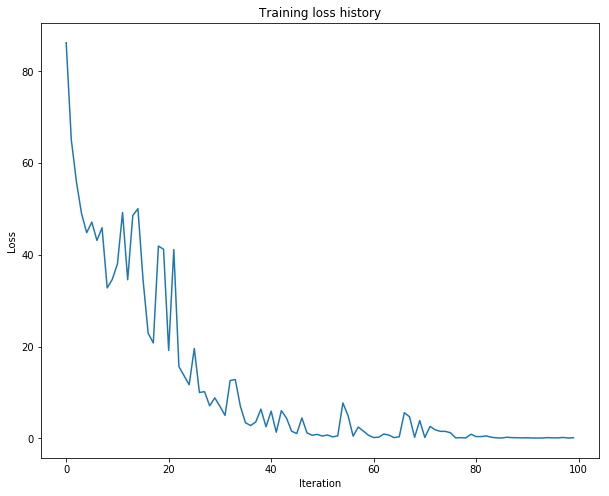

In [9]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='gru',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train(best=False, early_stop=False)

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# GRU test-time sampling

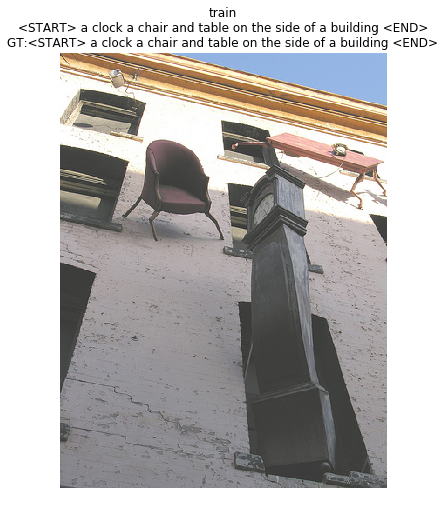

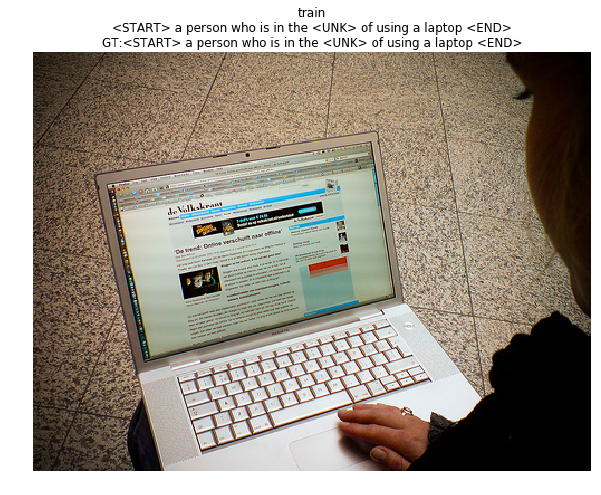

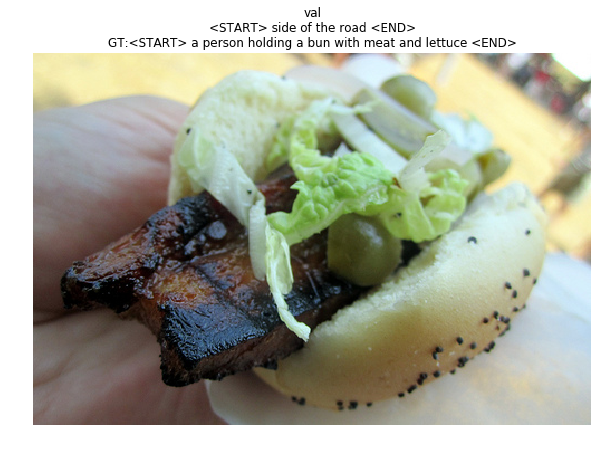

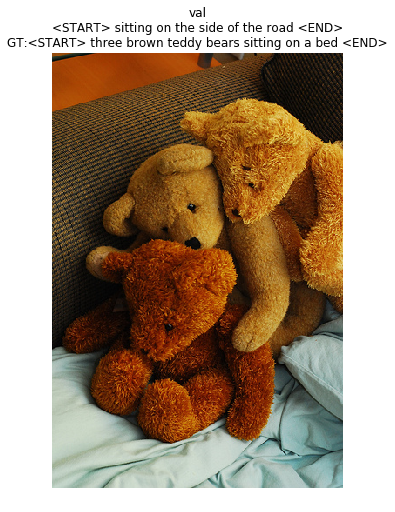

In [10]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Train captioning model!

(Iteration 1 / 500) loss: 83.076200 val_mean_loss: 999.900000 best val loss: 99999.900000
(Iteration 11 / 500) loss: 50.431885 val_mean_loss: 999.900000 best val loss: 99999.900000
(Iteration 21 / 500) loss: 43.595308 val_mean_loss: 55.188720 best val loss: 55.188720
(Iteration 31 / 500) loss: 42.603133 val_mean_loss: 55.188720 best val loss: 55.188720
(Iteration 41 / 500) loss: 36.361812 val_mean_loss: 53.342804 best val loss: 53.342804
(Iteration 51 / 500) loss: 27.710470 val_mean_loss: 53.342804 best val loss: 53.342804
(Iteration 61 / 500) loss: 30.259904 val_mean_loss: 53.325698 best val loss: 53.325698
(Iteration 71 / 500) loss: 25.338619 val_mean_loss: 53.325698 best val loss: 53.325698
(Iteration 81 / 500) loss: 19.541995 val_mean_loss: 53.832167 best val loss: 53.325698
(Iteration 91 / 500) loss: 20.260732 val_mean_loss: 53.832167 best val loss: 53.325698
(Iteration 101 / 500) loss: 18.093623 val_mean_loss: 55.195310 best val loss: 53.325698
(Iteration 111 / 500) loss: 20.4687

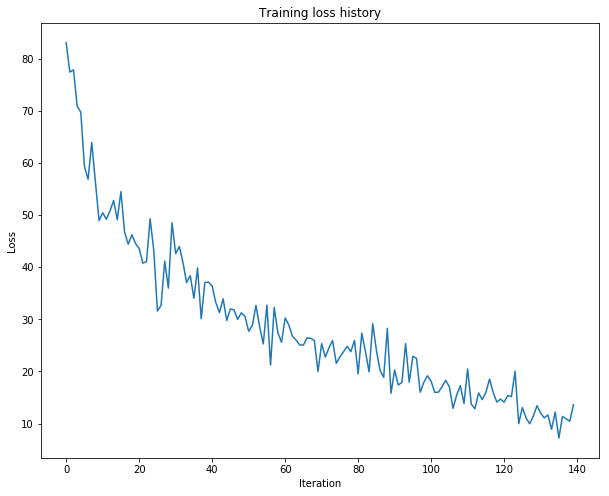

In [11]:
small_data = load_coco_data(max_train=500)

small_lstm_model = CaptioningRNN(
          cell_type='gru',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=25,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )
# training cut added to train with validation split
small_lstm_solver.train(best=True, early_stop=True)

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()


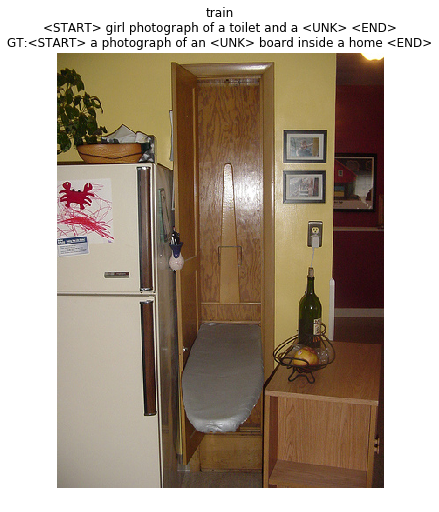

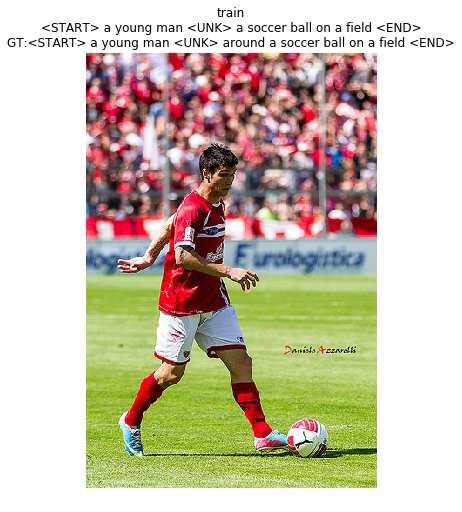

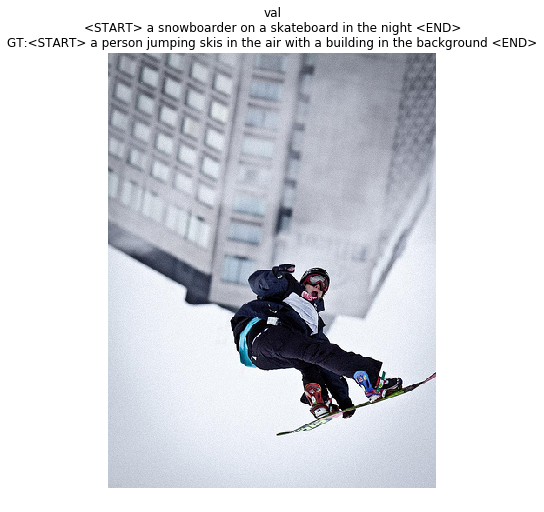

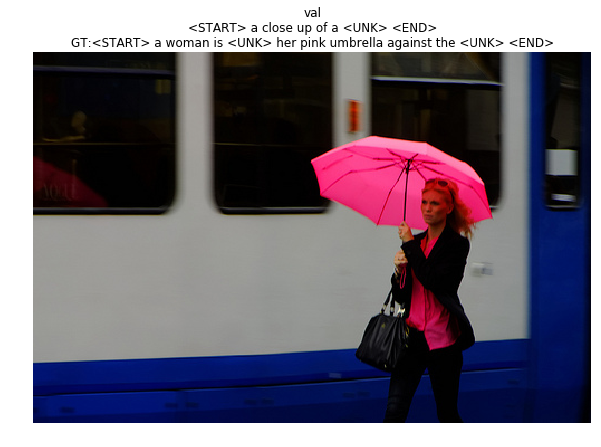

In [12]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()